## Predictive modeling of future customer demand trends

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

In [2]:
df = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MBAinfo_Retail_Clean_update.xlsx'
df = pd.read_excel(df)

df.head()

,Material,Year/Period,Retail_sales
0,110,2020-04-01,183175
1,111,2020-04-01,243
2,112,2020-04-01,2096
3,113,2020-04-01,1673
4,120,2020-04-01,178781


In [3]:
jdf = '/Users/sseyeoni/Documents/jupyter/Cintas/Results/MARA_Clean.xlsx'
jdf = pd.read_excel(jdf)

jdf = jdf[['Material','Material Group']]
jdf.head()

,Material,Material Group
0,1,TRAINING
1,110,MISC_FA
2,112,MISC_FA
3,113,MISC_FA
4,120,MISC_FA


In [4]:
# perform left join on the 'Material' column
left_join = pd.merge(df, jdf, on='Material', how='left')
left_join.head()

,Material,Year/Period,Retail_sales,Material Group
0,110,2020-04-01,183175,MISC_FA
1,111,2020-04-01,243,NaN
2,112,2020-04-01,2096,MISC_FA
3,113,2020-04-01,1673,MISC_FA
4,120,2020-04-01,178781,MISC_FA


In [5]:
df = left_join
df = df.rename(columns={'Year/Period':'Date', 'Retail_sales':'Retail_Value'})

In [6]:
# extract the rows of each Material Group

TREATMENT = df[df['Material Group'] == 'TREATMENT']

TABLETS = df[df['Material Group'] == 'TABLETS']

BANDAGES = df[df['Material Group'] == 'BANDAGES']

HANDPROT = df[df['Material Group'] == 'HANDPROT']

EYEPROT = df[df['Material Group'] == 'EYEPROT']

DRESSING = df[df['Material Group'] == 'DRESSING']

EMERG_FA = df[df['Material Group'] == 'EMERG_FA']

INSTRUMNT = df[df['Material Group'] == 'INSTRUMNT']

SKINCARE = df[df['Material Group'] == 'SKINCARE']

In [7]:
# Change Material_Group
Material_Group = DRESSING

In [8]:
# Each Material Group's retail value grouped by each date !!!!!!!!!!!!!
gdf = Material_Group.groupby('Date')['Retail_Value'].sum()
gdf = gdf.reset_index()
gdf.head()

,Date,Retail_Value
0,2020-04-01,141756
1,2020-05-01,136400
2,2020-06-01,179926
3,2020-07-01,203926
4,2020-08-01,202134


In [9]:
gdf.Date = pd.to_datetime(gdf.Date)

gdf = gdf.set_index("Date")
gdf.head()

,Retail_Value
Date,
2020-04-01,141756
2020-05-01,136400
2020-06-01,179926
2020-07-01,203926
2020-08-01,202134


In [10]:
gdf.tail()

,Retail_Value
Date,
2022-11-01,261557
2022-12-01,303500
2023-01-01,287942
2023-02-01,270356
2023-03-01,300011


### Rolling Statistics

<AxesSubplot: xlabel='Date'>

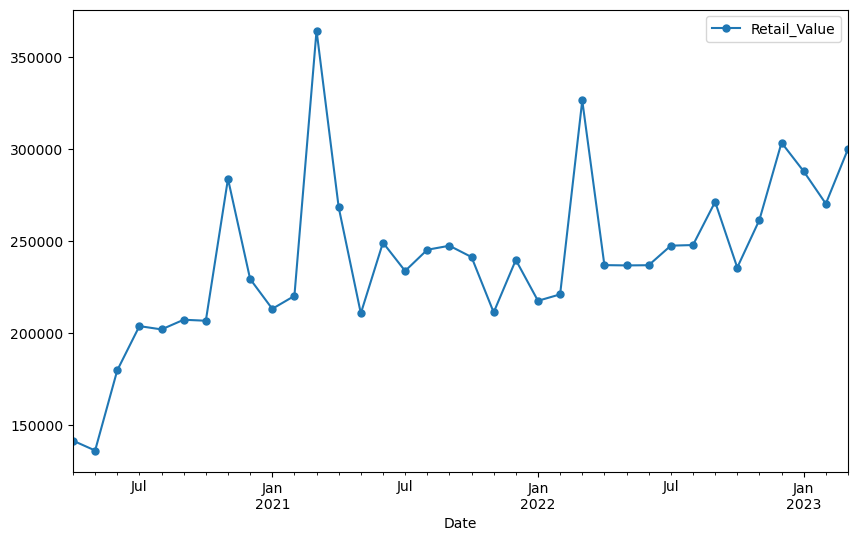

In [11]:
gdf['Retail_Value'].plot(figsize = (10,6), legend=True, marker='o', markersize=5)

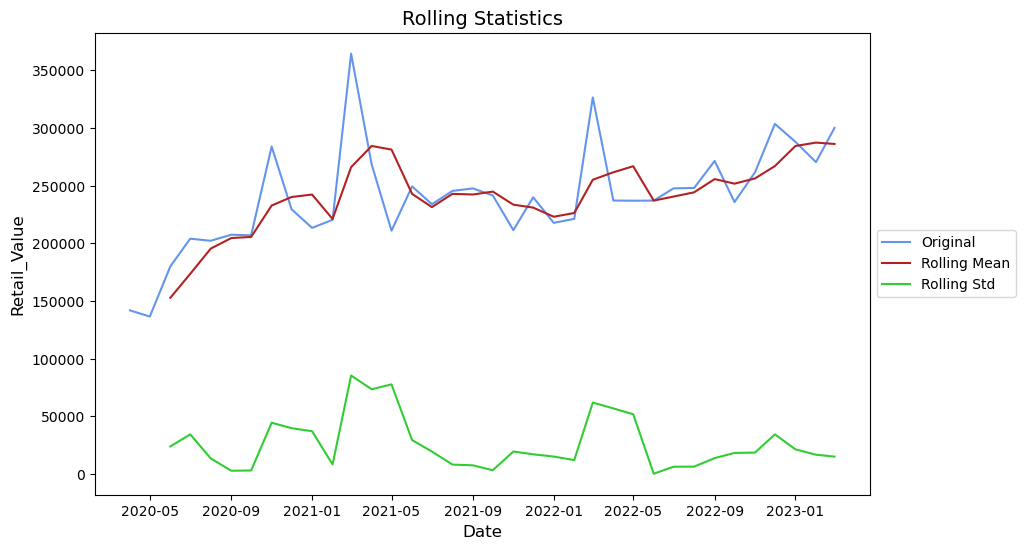

In [12]:
rolling_mean = gdf.rolling(window=3).mean()
rolling_std = gdf.rolling(window=3).std()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(gdf, color='cornflowerblue', label='Original')
ax.plot(rolling_mean, color='firebrick', label='Rolling Mean')
ax.plot(rolling_std, color='limegreen', label='Rolling Std')

ax.set_xlabel('Date', size=12)
ax.set_ylabel('Retail_Value', size=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Rolling Statistics', size=14)

plt.show()

### Acf (Autocorrelation)

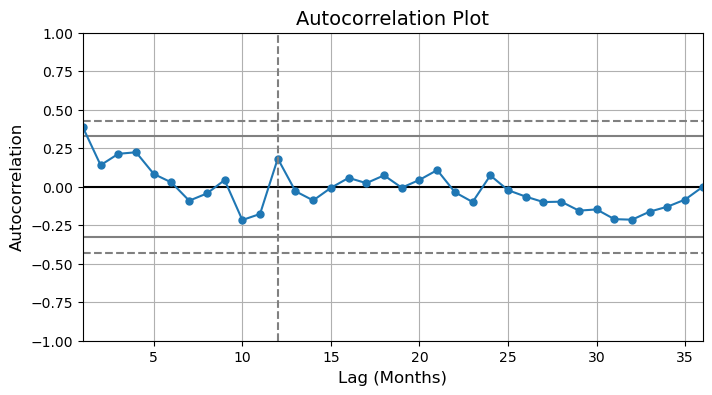

In [13]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

plt.figure(figsize=(8, 4))
pd.plotting.autocorrelation_plot(gdf['Retail_Value'], marker='o', markersize=5)
plt.axvline(x=12, linestyle='--', color='grey')
plt.xlabel('Lag (Months)', fontsize=12)  # explicitly reference the xlabel function from matplotlib.pyplot
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation Plot', fontsize=14)
plt.show()

### Pacf (Partial Autocorrelation)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x400 with 0 Axes>

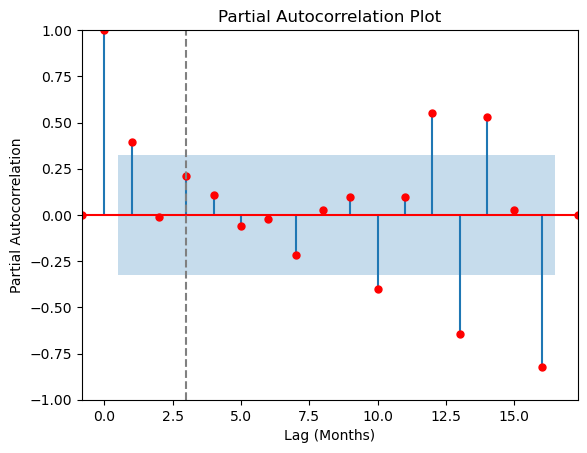

In [14]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
# assume gdf is a pandas DataFrame containing the time series data

plt.figure(figsize=(8, 4))
plot_pacf(gdf['Retail_Value'], lags=16, marker='o', markersize=5, color='red')
plt.axvline(x=3, linestyle='--', color='grey')
plt.xlabel('Lag (Months)')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.show()

### Decomposition

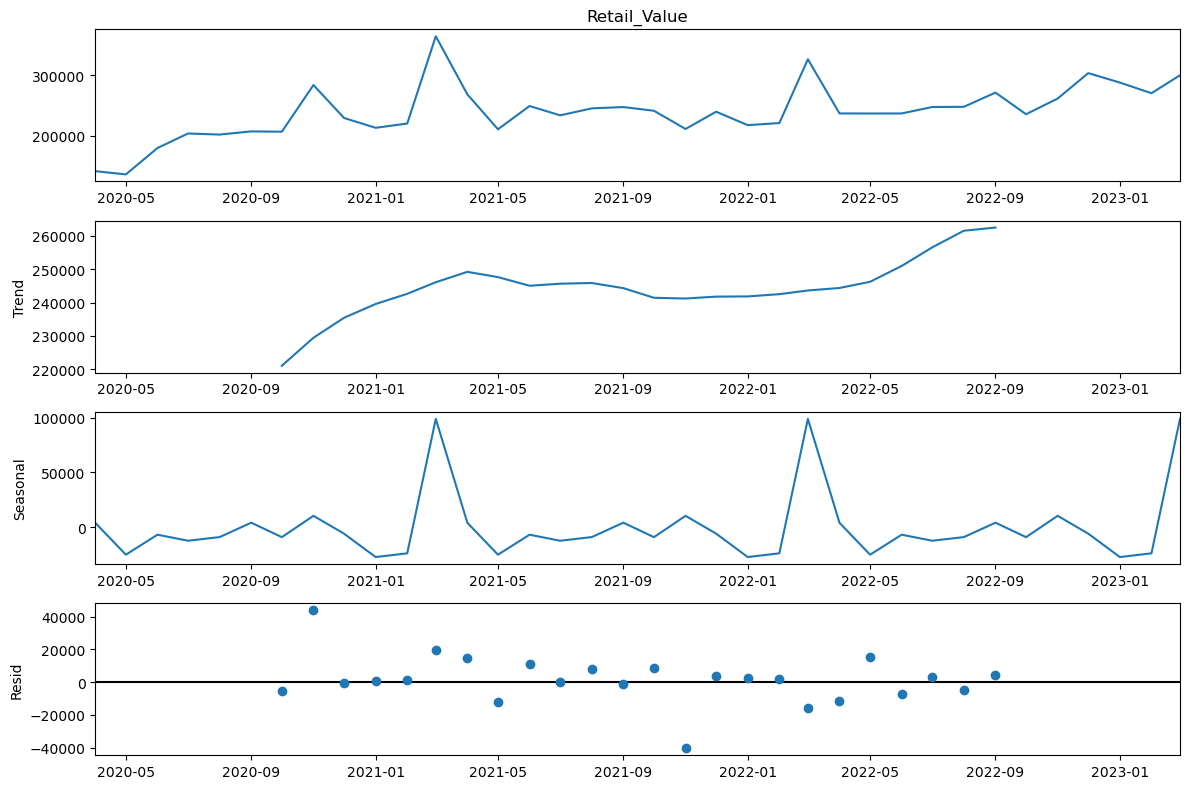

In [15]:
rcParams['figure.figsize'] = 12, 8
dec = seasonal_decompose(gdf["Retail_Value"], model = "add")
dec.plot();

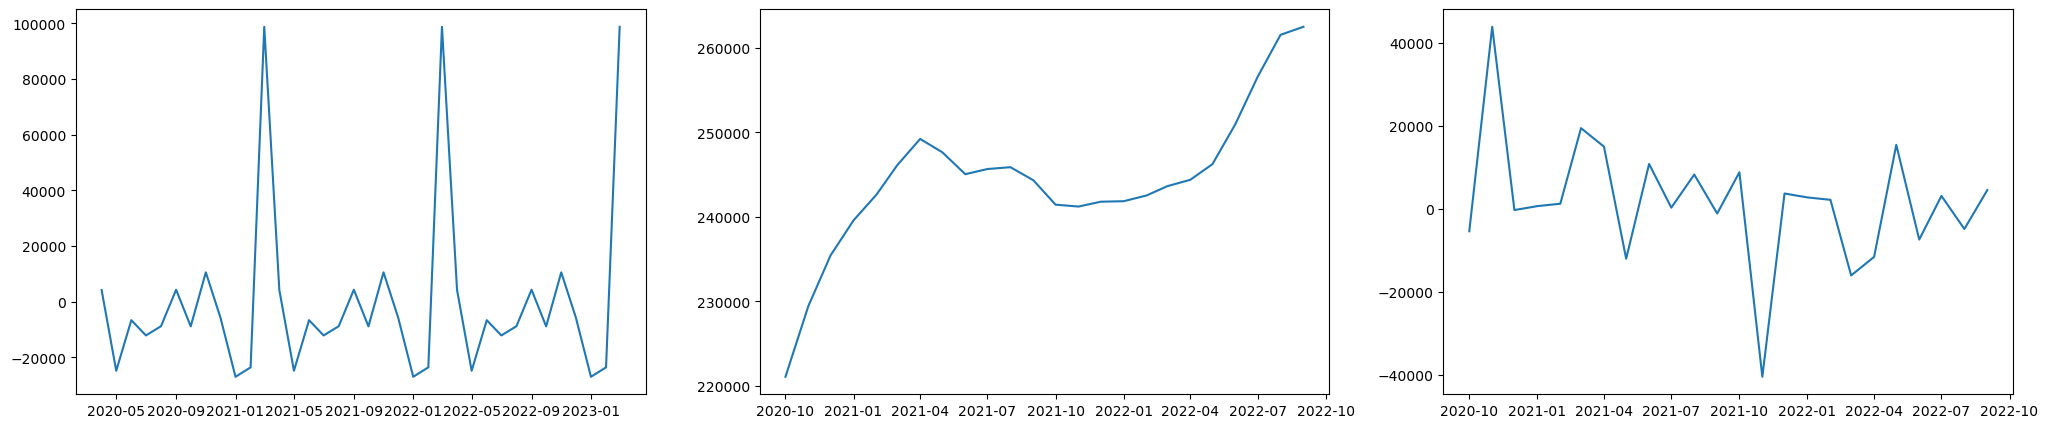

In [16]:
plt.figure(figsize = (25, 5))
a = seasonal_decompose(gdf["Retail_Value"], model = "add")
plt.subplot(1, 3, 1)
plt.plot(dec.seasonal)

plt.subplot(1, 3, 2)
plt.plot(dec.trend)

plt.subplot(1, 3, 3)
plt.plot(dec.resid)

plt.show()

In [17]:
# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(gdf['Retail_Value'])
print('ADF Statistic: {:.3f}'.format(result[0]))
print('p-value: {:.3f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: -3.945
p-value: 0.002
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


## Forecasting Model

**ARIMA Model** stands for Auto-Regressive Integrated Moving Average.<br> It is is used for predicting future trends on a time series data. It is model that form of regression analysis.

**Auto-Regressive** models predict future behavior using past behavior where there is some correlation between past and future data.

**Integration** is the difference between present and previous observations. It is used to make the time series stationary.

**Moving Average** is a statistical method that takes the updated average of values to help cut down on noise. It takes the average over a specific interval of time

**p**: Value just before convergence in pacf. ( =3 )<br>
**d** : Check whether there is a trend by adf test and visual confirmation of the trend ( =0 )<br>
**q** : value just before convergence in acf ( =1)<br>
**P** : Check how many times the seasonality cycle was repeated in the pacf ( =0 )<br>
**D**: Check whether there is seasonality, 1 or 0 ( =0 ) depending on the need for seasonality difference <br>
**Q**: Check how many times the seasonal cycle based on acf has been repeated (=1)<br>
**m** : seasonal period ( =12 )

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = gdf[:len(gdf)-12]
test_data = gdf[len(gdf)-12:]

arima_model = SARIMAX(gdf['Retail_Value'], order = (1,1,5), seasonal_order = (0,1,0,12))
arima_result = arima_model.fit()
arima_result.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.98999D+00    |proj g|=  3.57807D+00

At iterate    5    f=  9.39381D+00    |proj g|=  1.99594D-01

At iterate   10    f=  9.37843D+00    |proj g|=  1.75552D-01

At iterate   15    f=  9.19273D+00    |proj g|=  1.69442D+00

At iterate   20    f=  8.89922D+00    |proj g|=  1.51752D-01

At iterate   25    f=  8.89444D+00    |proj g|=  2.72852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     35      1     0     0   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Retail_Value   No. Observations:                   36
Model:             SARIMAX(1, 1, 5)x(0, 1, [], 12)   Log Likelihood                -320.200
Date:                             Thu, 27 Apr 2023   AIC                            654.399
Time:                                     16:40:40   BIC                            662.348
Sample:                                 04-01-2020   HQIC                           656.398
                                      - 03-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7445      0.033    -22.780      0.000      -0.809      -0.680
ma.L1          0.7928      0.045     17.468      0.000       0.704       0.882
ma.L2         -0.0821      0.036     -2.253      0.024      -0.153      -0.011
ma.L3         -0.0444      0.031     -1.450      0.147      -0.104       0.016
ma.L4          0.1204      0.038      3.152      0.002       0.046       0.195
ma.L5          0.2053      0.022      9.234      0.000       0.162       0.249
sigma2      1.985e+08   5.07e-11   3.92e+18      0.000    1.99e+08    1.99e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.31   Prob(JB):                         0.68
Heteroskedasticity (H):               0.75   Skew:                             0.25
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.8e+35. Standard errors may be unstable.
"""

In [20]:
arima_pred = arima_result.predict(start = len(train_data), end = len(gdf)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2022-04-01    236311.025763
2022-05-01    188900.391291
2022-06-01    269121.774979
2022-07-01    217415.253409
2022-08-01    259705.375413
2022-09-01    254007.088951
2022-10-01    268700.605087
2022-11-01    197689.350158
2022-12-01    305667.497505
2023-01-01    265489.616257
2023-02-01    301202.678134
2023-03-01    366075.386447
Freq: MS, Name: ARIMA Predictions, dtype: float64

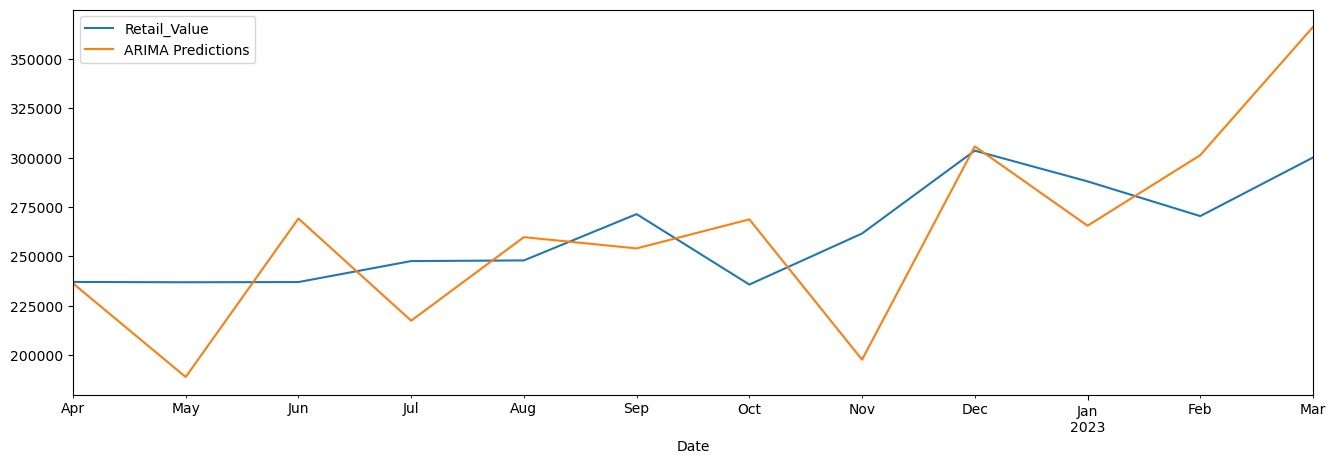

In [21]:
test_data['Retail_Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [22]:
from statsmodels.tools.eval_measures import rmse

arima_rmse_error = rmse(test_data['Retail_Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = gdf['Retail_Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 1306454408.4976087
RMSE Error: 36144.90847266885
Mean: 239991.75


In [23]:
arima_pred_f = arima_result.predict(start = len(gdf), end = len(gdf)+12, typ="levels").rename("ARIMA Predictions")
arima_pred_f

2023-04-01    228956.052081
2023-05-01    224192.119345
2023-06-01    231548.902764
2023-07-01    222477.706334
2023-08-01    223917.405105
2023-09-01    246531.433091
2023-10-01    211490.656269
2023-11-01    236882.593530
2023-12-01    279164.393013
2024-01-01    263354.152872
2024-02-01    245955.948580
2024-03-01    275471.132499
2024-04-01    204520.279273
Freq: MS, Name: ARIMA Predictions, dtype: float64

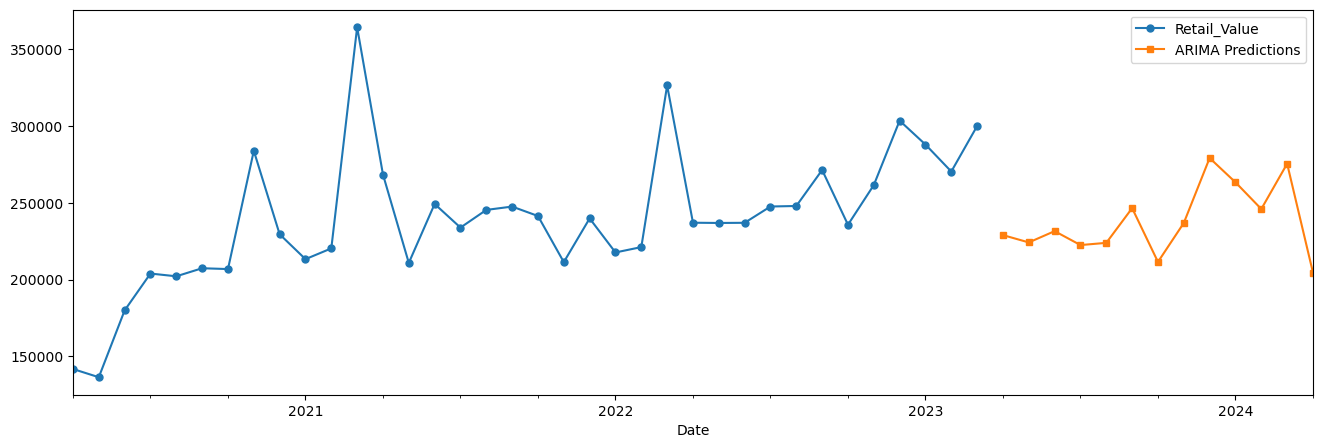

In [24]:
gdf['Retail_Value'].plot(figsize = (16,5), legend=True, marker='o', markersize=5)
arima_pred_f.plot(legend = True, marker='s', markersize=5);

In [25]:
pdf = arima_pred_f.to_frame(name='Retail_Value')
pdf.head()

,Retail_Value
2023-04-01,228956.052081
2023-05-01,224192.119345
2023-06-01,231548.902764
2023-07-01,222477.706334
2023-08-01,223917.405105


In [26]:
udf = pd.concat([gdf, pdf])

udf.reset_index(inplace=True)
udf = udf.rename(columns = {'index':'Date'})

In [27]:
udf.head()

,Date,Retail_Value
0,2020-04-01,141756.0
1,2020-05-01,136400.0
2,2020-06-01,179926.0
3,2020-07-01,203926.0
4,2020-08-01,202134.0


In [28]:
udf.to_csv('/Users/sseyeoni/Documents/jupyter/Cintas/Forecasting/Results/Retail_Predictive_Model_DRESSING.csv', index=False)